In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
color_pal = sns.color_palette()
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [2]:
import sqlite3

conn = sqlite3.connect('../data/WARP.db')
df = pd.read_sql_query("SELECT * FROM master_warp", conn)
conn.close()
# change datetime to index
df.set_index('target_datetime', inplace=True)
# convert to datetime
df.index = pd.to_datetime(df.index)
print(df.dtypes)


hour                          int64
day_of_week                   int64
month                         int64
day_of_year                   int64
hour_sin                    float64
hour_cos                    float64
weekday_sin                 float64
weekday_cos                 float64
yearday_sin                 float64
yearday_cos                 float64
local_datetime               object
is_dst                        int64
is_holiday                    int64
is_weekend                    int64
is_non_working_day            int64
Load                        float64
Price                       float64
Flow_BE                     float64
Flow_DE                     float64
Flow_GB                     float64
Flow_DK                     float64
Flow_NO                     float64
Total_Flow                  float64
temperature_2m              float64
wind_speed_10m              float64
apparent_temperature        float64
cloud_cover                 float64
snowfall                    

/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_17408/3597398167.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  tomorrow = pd.Timestamp(datetime.datetime.utcnow().date() + pd.Timedelta(days=1), tz='UTC')


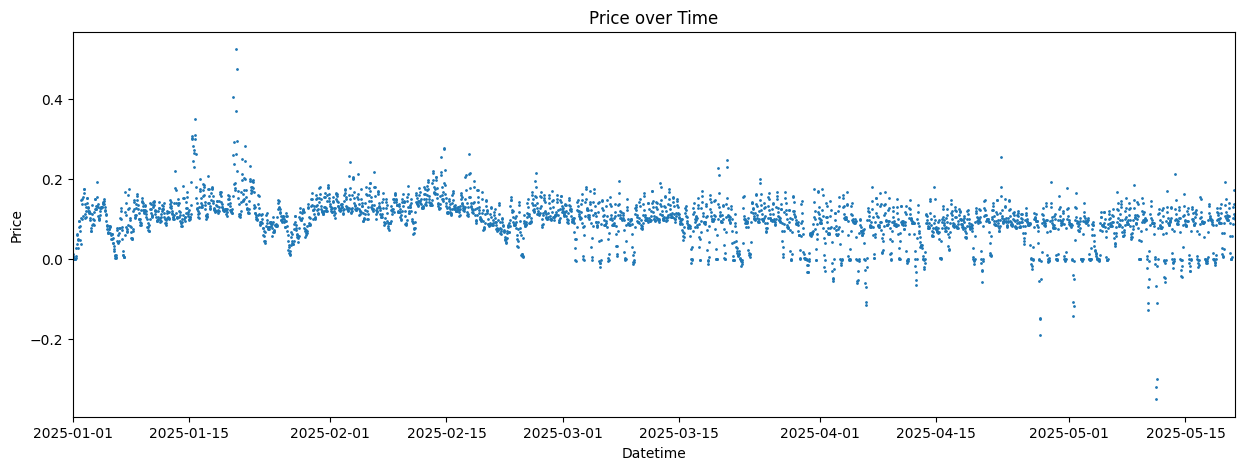

In [3]:
# Get tomorrow's date in UTC (since target_datetime is UTC), to limit the x-axis
tomorrow = pd.Timestamp(datetime.datetime.utcnow().date() + pd.Timedelta(days=1), tz='UTC')

plt.figure(figsize=(15, 5))
plt.plot(df.index, df['Price'], '.', color=color_pal[0], markersize=2)
plt.title('Price over Time')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.xlim(df.index.min(), tomorrow)
plt.show()

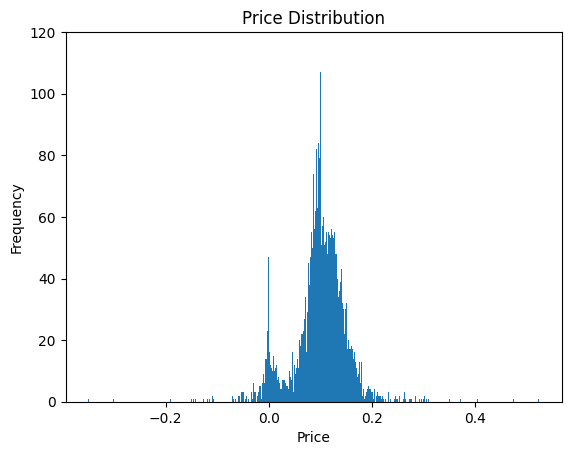

In [4]:
df['Price'].plot(kind='hist', bins=500)
plt.ylim(top=120)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define color palette
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Set up TSS and filter data
tss = TimeSeriesSplit(n_splits=5, test_size=24*6, gap=36)
df = df.sort_index()

# Only use data before '2025-03-20' for training/validation
max_train_date = pd.Timestamp("2025-04-01", tz='UTC')
df_limited = df[df.index < max_train_date]

# Only allow validation sets up to '2025-05-15'
max_val_date = pd.Timestamp("2025-05-15", tz='UTC')

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
fold = 0

for train_idx, val_idx in tss.split(df_limited):
    if fold >= 5:
        break  # Only plot the first 5 folds to match the number of subplots

    train = df_limited.iloc[train_idx].copy()
    val = df_limited.iloc[val_idx].copy()
    val = val[val.index <= max_val_date]

    train['Price'].plot(ax=axs[fold], color=color_pal[0], label='Train', alpha=0.5)
    val['Price'].plot(ax=axs[fold], color=color_pal[1], label='Validation', alpha=0.5)
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    axs[fold].legend()
    axs[fold].set_title(f"Fold {fold + 1}")
    fold += 1

plt.xlabel("Datetime")
plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
import numpy as np
import json
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from datetime import datetime

# Configuration
MODEL_CODE = "XGB_default"
PARAMETERS_USED = {
    "temp_2m": True,
    "solar_vol": True
}
timestamp_predict = datetime.now().strftime('%d-%m-%Y %H:%M')

# TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24*6, gap=36)
df = df.sort_index()

# Results storage
results = []
fold = 0

# Loop over folds
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    FEATURES = [
        'Load', 'Flow_NO', 'yearday_cos', 'yearday_sin', 'month',
        'shortwave_radiation', 'apparent_temperature', 'temperature_2m',
        'Flow_GB', 'direct_normal_irradiance', 'diffuse_radiation',
        'cloud_cover', 'Flow_BE', 'hour_cos', 'hour_sin', 'is_non_working_day',
        'weekday_sin', 'weekday_cos', 'is_holiday', 'Flow_DE'
    ]
    TARGET = 'Price'

    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1200,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.02
    )

    reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )

    y_pred = reg.predict(X_test)

    # Store predictions
    y_test.index = pd.to_datetime(y_test.index)
    pred_df = pd.DataFrame({
        'datetime': y_test.index,
        'y_true': y_test.values,
        'y_pred': y_pred
    })

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Fold {fold + 1} - RMSE: {rmse:.4f}")

    for _, row in pred_df.iterrows():
        results.append({
            'timestamp_predict': timestamp_predict,
            'datetime': row['datetime'].strftime('%d-%m-%Y %H:%M'),
            'model_code': MODEL_CODE,
            'price': round(row['y_pred'], 4),
            'true_price': round(row['y_true'], 4),
            'RSME': round(rmse, 4),
            'fold': fold + 1,
            'parameters(JSON)': json.dumps(PARAMETERS_USED)
        })

    fold += 1

# Save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("model_results_log.csv", mode='a', index=False)

[0]	validation_0-rmse:0.39419	validation_1-rmse:0.41548
[100]	validation_0-rmse:0.05966	validation_1-rmse:0.05525
[200]	validation_0-rmse:0.02469	validation_1-rmse:0.02893
[300]	validation_0-rmse:0.02129	validation_1-rmse:0.02868
[400]	validation_0-rmse:0.01971	validation_1-rmse:0.02855
[416]	validation_0-rmse:0.01950	validation_1-rmse:0.02849
Fold 1 - RMSE: 0.0285
[0]	validation_0-rmse:0.39557	validation_1-rmse:0.44585
[100]	validation_0-rmse:0.05983	validation_1-rmse:0.10203
[200]	validation_0-rmse:0.02502	validation_1-rmse:0.06878
[300]	validation_0-rmse:0.02172	validation_1-rmse:0.06597
[328]	validation_0-rmse:0.02117	validation_1-rmse:0.06599
Fold 2 - RMSE: 0.0659
[0]	validation_0-rmse:0.39763	validation_1-rmse:0.42242
[100]	validation_0-rmse:0.06060	validation_1-rmse:0.09322
[200]	validation_0-rmse:0.02587	validation_1-rmse:0.05407
[300]	validation_0-rmse:0.02244	validation_1-rmse:0.04543
[400]	validation_0-rmse:0.02082	validation_1-rmse:0.04021
[500]	validation_0-rmse:0.01958	va

In [17]:
# Calculate and print the average RMSE across all folds
avg_rmse = np.mean([res['RSME'] for res in results])
print(f"Average RMSE across all folds: {avg_rmse:.4f}")

Average RMSE across all folds: 0.0358


In [ ]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from datetime import datetime
import os

tss = TimeSeriesSplit(n_splits=5, test_size=24*6, gap=36)
df = df.sort_index()

FEATURES = [
    'Load', 'Flow_NO', 'yearday_cos', 'yearday_sin', 'month',
    'shortwave_radiation', 'apparent_temperature', 'temperature_2m',
    'Flow_GB', 'direct_normal_irradiance', 'diffuse_radiation',
    'cloud_cover', 'Flow_BE', 'hour_cos', 'hour_sin', 'is_non_working_day',
    'weekday_sin', 'weekday_cos', 'is_holiday', 'Flow_DE'
]
TARGET = 'Price'
PARAMETERS_USED = ['temperature_2m', 'shortwave_radiation']  # example of most relevant features
MODEL_CODE = 'XGB_default'  # replace with your real model identifier
timestamp_predict = datetime.now().strftime('%d-%m-%Y %H:%M')

results = []

for fold, (train_idx, val_idx) in enumerate(tss.split(df)):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01
    )

    reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=0
    )

    y_pred = reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    for dt, pred in zip(y_test.index, y_pred):
        results.append({
            'timestamp_predict': timestamp_predict,
            'datetime': dt.strftime('%d-%m-%Y %H:%M'),
            'model_code': MODEL_CODE,
            'price_pred': round(float(pred), 4),
            'true_price': round(row[y_true'], 4),
            'RSME': round(float(rmse), 4),
            'parameters(JSON)': json.dumps(PARAMETERS_USED)
        })
# Convert to DataFrame
results_df = pd.DataFrame(results)

# Append to a CSV file
results_df.to_csv('model_predictions_log.csv', mode='a', header=not os.path.exists('model_predictions_log.csv'), index=False)


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb

tss = TimeSeriesSplit(n_splits=5, test_size=24*6, gap=36)
df = df.sort_index()
fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    FEATURES = [
        'Load', 'Flow_NO', 'yearday_cos', 'yearday_sin', 'month',
        'shortwave_radiation', 'apparent_temperature', 'temperature_2m',
        'Flow_GB', 'direct_normal_irradiance', 'diffuse_radiation',
        'cloud_cover', 'Flow_BE', 'hour_cos', 'hour_sin', 'is_non_working_day',
        'weekday_sin', 'weekday_cos', 'is_holiday', 'Flow_DE'
    ]
    TARGET = 'Price'

    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01
    )

    reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    fold += 1
    print(f"Fold {fold} - RMSE: {scores[-1]:.4f}")

In [ ]:

print(f"Fold scores: {scores}")
avg_score = np.mean(scores)
print(f"Average RMSE across folds: {avg_score:.4f}")


In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*6, gap=36)
df = df.sort_index()
fold = 0
preds = []
scores = []

for train_idx, val_idx in tss. split(df) :
train = df.iloc[train_idx]
test = df.iloc[val_idx]
train = create_features (train)
test = create_features(test)
FEATURES = ['Load',	'Flow_NO', 'yearday_cos', 'yearday_sin', 'month','shortwave_radiation', 'apparent_temperature','temperature_2m', 
	'Flow_GB','direct_normal_irradiance','diffuse_radiation','cloud_cover','Flow_BE','hour_cos','hour_sin','is_non_working_day',
    'weekday_sin','weekday_cos','is_holiday','Flow_DE']

TARGET = 'Price'
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=1000,
    early_stopping_rounds=50,
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=0.01
)
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)


In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*6, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]
    # Filter validation set by max_val_date
    val = val[val.index <= max_val_date]

    # Create features and labels
    X_train = train.drop(columns=['Price'])
    y_train = train['Price']
    X_val = val.drop(columns=['Price'])
    y_val = val['Price']

    # Train the model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Make predictions
    preds.append(model.predict(X_val))
    scores.append(mean_squared_error(y_val, preds[-1], squared=False))

    fold += 1
# Plot predictions
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]
    # Filter validation set by max_val_date
    val = val[val.index <= max_val_date]

    # Create features and labels
    X_train = train.drop(columns=['Price'])
    y_train = train['Price']
    X_val = val.drop(columns=['Price'])
    y_val = val['Price']

    # Train the model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Make predictions
    preds.append(model.predict(X_val))
    scores.append(mean_squared_error(y_val, preds[-1], squared=False))

    fold += 1

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from datetime import timedelta

# Feature and target setup
features = [
    'apparent_temperature',
    'temperature_2m',
    'direct_normal_irradiance',
    'diffuse_radiation',
    'yearday_sin',
    'Flow_BE',
    'hour_sin',
    'is_non_working_day',
    'is_dst',
    'is_weekend',
    'is_holiday',
    'weekday_cos',
    'wind_speed_10m',
    'hour_cos',
    'weekday_sin',
    'cloud_cover',
    'Flow_GB',
    'yearday_cos',
    'Flow_NO',
    'Load'
]
target = 'Price'

# Safe datetime handling
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')
    df = df.set_index('datetime')
else:
    print("'datetime' column not found in columns. Sorting by index instead.")
    df = df.sort_index()

# Forecast settings
start_date = pd.Timestamp("2025-03-13 12:00", tz='UTC')
end_date = pd.Timestamp("2025-05-19 12:00", tz='UTC')
lag = timedelta(hours=36)
forecast_horizon = timedelta(hours=144)

# Store RMSEs
rmses = []

current_time = start_date
while current_time <= end_date:
    train_data = df[df.index < current_time]
    test_start = current_time + lag # check current time  
    test_end = test_start + forecast_horizon
    test_data = df[(df.index >= test_start) & (df.index < test_end)]

    if test_data.empty:
        print(f"No test data for forecast starting at {current_time}")
        current_time += timedelta(days=1)
        continue

    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]

    # Train and predict
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmses.append(rmse)

    print(f"Forecast origin: {current_time}, Predicting {test_start} to {test_end}, RMSE: {rmse:.3f}")

    current_time += timedelta(days=1)

# Summary
avg_rmse = np.mean(rmses)
print(f"\nAverage RMSE over {len(rmses)} runs: {avg_rmse:.3f}")

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from datetime import timedelta

# Feature and target setup
features = ['hour_cos', 'Load', 'hour_sin', 'weekday_sin', 'weekday_cos', 'Solar_Vol', 'Wind_Vol',
            'WindOffshore_Vol', 'is_holiday','Total_Flow']

target = 'Price'

# Safe datetime handling
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')
    df = df.set_index('datetime')
else:
    print("'datetime' column not found in columns. Sorting by index instead.")
    df = df.sort_index()

# Forecast settings
start_date = pd.Timestamp("2025-03-13 12:00", tz='UTC')
end_date = pd.Timestamp("2025-05-05 12:00", tz='UTC')
lag = timedelta(hours=36)
forecast_horizon = timedelta(hours=144)

# Store RMSEs
rmses = []

current_time = start_date
while current_time <= end_date:
    train_data = df[df.index < current_time]
    test_start = current_time + lag
    test_end = test_start + forecast_horizon
    test_data = df[(df.index >= test_start) & (df.index < test_end)]

    if test_data.empty:
        print(f"No test data for forecast starting at {current_time}")
        current_time += timedelta(days=1)
        continue

    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]

    # Train and predict
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmses.append(rmse)

    print(f"Forecast origin: {current_time}, Predicting {test_start} to {test_end}, RMSE: {rmse:.3f}")

    current_time += timedelta(days=1)

# Summary
avg_rmse = np.mean(rmses)
print(f"\nAverage RMSE over {len(rmses)} runs: {avg_rmse:.3f}")

In [ ]:
# Extract the forecast origin dates and RMSEs from the previous loop
forecast_origins = []
rmses_per_run = []

start_date = pd.Timestamp("2025-03-13 12:00", tz='UTC')
end_date = pd.Timestamp("2025-05-05 12:00", tz='UTC')
num_runs = len(rmses)
current_time = start_date

for i in range(num_runs):
    forecast_origins.append(current_time)
    current_time += timedelta(days=1)

# Plot RMSE vs. forecast origin date
plt.figure(figsize=(15, 5))
plt.plot(forecast_origins, rmses, marker='o', linestyle='-', color=color_pal[0])
plt.title('RMSE vs. First Predicted Date (per run)')
plt.xlabel('Forecast Origin (First Predicted Date)')
plt.ylabel('RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Calculate RMSE per day (averaged over all runs where the day is included in the forecast horizon)

# Assume forecast_origins and rmses are available from previous cells
# Each run predicts 6 days (144 hours), so for each run, map RMSE to each predicted day

# Build a DataFrame mapping each forecast run to its predicted days
forecast_horizon_days = 6
forecast_origin_dates = pd.to_datetime(forecast_origins)
rmse_per_day = {}

for run_idx, origin in enumerate(forecast_origin_dates):
    for day_offset in range(forecast_horizon_days):
        day = (origin + pd.Timedelta(hours=36) + pd.Timedelta(days=day_offset)).normalize()
        if day not in rmse_per_day:
            rmse_per_day[day] = []
        rmse_per_day[day].append(rmses[run_idx])

# Compute average RMSE per day
avg_rmse_per_day = pd.Series({day: np.mean(vals) for day, vals in rmse_per_day.items()})
avg_rmse_per_day = avg_rmse_per_day.sort_index()

# Plot
plt.figure(figsize=(15, 5))
plt.plot(avg_rmse_per_day.index, avg_rmse_per_day.values, marker='o', linestyle='-', color=color_pal[1])
plt.title('Average RMSE per Predicted Day (Averaged over all runs)')
plt.xlabel('Predicted Day')
plt.ylabel('Average RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Get feature importances from the last trained model
importances = model.feature_importances_
feature_names = model.feature_names_in_

# Create a DataFrame for better visualization
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feat_imp_df)

# Optional: Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()